In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pyvi

In [ ]:
import numpy as np
import pandas as pd
import re
from pyvi import ViTokenizer

### Tiền xử lý đữ liệu

In [ ]:
pathdata = '/content/drive/MyDrive/Data full/merged_data (2).txt'
stopwords_path = '/content/drive/MyDrive/Data full/stopwords.csv'

model_path = '/content/drive/MyDrive/Data full/word2vec_model.model'

In [ ]:
# Đọc dữ liệu từ file
train_data = pd.read_csv(pathdata, delimiter='\t', header=None, names=['text'])
train_data['text_tokenized'] = train_data['text'].apply(ViTokenizer.tokenize)
train_data

,text,text_tokenized
0,Việt Nam quốc hiệu là Cộng hòa Xã hội chủ ngh...,Việt_Nam quốc_hiệu là Cộng_hòa Xã_hội chủ_nghĩ...
1,Lãnh thổ Việt Nam xuất hiện con người sinh sốn...,Lãnh_thổ Việt_Nam xuất_hiện con_người sinh_sốn...
2,Đến thời kỳ cận đại Việt Nam lần lượt trải qu...,Đến thời_kỳ cận_đại Việt_Nam lần_lượt trải qua...
3,Sau khi thống nhất Việt Nam tiếp tục gặp khó ...,Sau khi thống_nhất Việt_Nam tiếp_tục gặp khó_k...
4,Tên gọi,Tên gọi
...,...,...
12232,Y học Gerhard Domagk,Y_học Gerhard_Domagk
12233,Văn học Frans Eemil Sillanpää,Văn_học Frans Eemil_Sillanpää
12234,Hòa bình không có giải,Hòa_bình không có giải
12235,Xem thêm,Xem thêm


In [ ]:
# Đọc danh sách stopwords
stopwords_data = pd.read_csv(stopwords_path, sep="\t", encoding='utf-8')
stopwords_set = set(stopwords_data['stopwords'])
stopwords_data['stopwords'].head()

0      mà_thôi
1       tuy_có
2      đâu_như
3    quay_bước
4      hỏi_lại
Name: stopwords, dtype: object

In [ ]:
# Tiền xử lý dữ liệu
train_data['text_cleaned'] = train_data['text_tokenized'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords_set]))
train_data['text_cleaned']

0        Việt_Nam quốc_hiệu Cộng_hòa Xã_hội chủ_nghĩa V...
1        Lãnh_thổ Việt_Nam con_người sinh_sống thời_đại...
2        Đến thời_kỳ cận_đại Việt_Nam lần_lượt trải gia...
3        Sau thống_nhất Việt_Nam sụp_đổ tan_rã đồng_min...
4                                                  Tên gọi
                               ...                        
12232                                 Y_học Gerhard_Domagk
12233                        Văn_học Frans Eemil_Sillanpää
12234                                        Hòa_bình giải
12235                                                  Xem
12236                                            Tham_khảo
Name: text_cleaned, Length: 12237, dtype: object

In [ ]:
# Chuyển dữ liệu huấn luyện thành danh sách các từ
sentences = [text.split() for text in train_data['text_cleaned']]

### Xây dựng mô hình

In [ ]:
# Xây dựng từ điển từ vựng
word_vocab = {}
for sentence in sentences:
    for word in sentence:
        if word not in word_vocab:
            word_vocab[word] = len(word_vocab)

In [ ]:
# Tạo cặp từ (word pairs) bằng cách sử dụng cửa sổ xem xét (window size)
window_size = 5
word_pairs = []
for sentence in sentences:
    for i in range(len(sentence)):
        center_word = sentence[i]
        for j in range(max(0, i - window_size), min(i + window_size + 1, len(sentence))):
            if j != i:
                context_word = sentence[j]
                word_pairs.append((center_word, context_word))

In [ ]:
# Tính toán ma trận từ
vector_dim = 100
learning_rate = 0.01

In [ ]:
# Khởi tạo ma trận từ ngẫu nhiên
word_matrix = np.random.uniform(-0.8, 0.8, (len(word_vocab), vector_dim))

In [ ]:
# Hàm sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
# Huấn luyện ma trận từ
for center_word, context_word in word_pairs:
    center_index = word_vocab[center_word]
    context_index = word_vocab[context_word]

    center_vector = word_matrix[center_index]
    context_vector = word_matrix[context_index]

    score = sigmoid(np.dot(center_vector, context_vector))
    error = score - 1

    center_grad = error * context_vector
    context_grad = error * center_vector

    word_matrix[center_index] -= learning_rate * center_grad
    word_matrix[context_index] -= learning_rate * context_grad

In [ ]:
# Truy vấn vectơ từ cho một từ cụ thể
word_vector = word_matrix[word_vocab['Cộng_sản']]
print(word_vector)

[ 0.50286125  0.50120468 -0.0731717   0.36251051 -0.10212616 -0.73493423
 -0.65991502  0.17048919  0.18052051 -0.63439067  0.5892326  -0.50153755
  0.22299972  0.2518384  -0.24681676  0.12439714  0.09915807 -0.31790936
  0.4863296   0.341629    0.4978348   0.85359314 -0.24909856  0.38355987
  0.03149948 -0.42963295  0.30034371 -0.40107521  0.77650145  0.22487816
  0.26822742 -0.36546487 -0.45919748  0.29190904  0.52636028  0.225575
  0.21026439  0.35582117 -0.36075025  0.08914943 -0.47529348 -0.16085676
  0.48854208  0.16436005  0.323425    0.26218284 -0.18628062  0.08500066
 -0.68575365 -0.15039577 -0.31907656 -0.82212673  0.0655496   0.3526644
  0.48968049 -0.25506045 -0.28198931 -0.62366598  0.2009099   0.00241707
 -0.28396872 -0.72025203  0.4897569   0.07655959  0.5970378   0.2455143
 -0.39867931 -0.50404008 -0.11976105  0.3173207  -0.6919944   0.02766445
  0.69471522 -0.06953046 -0.00321836 -0.18343159  0.66553749 -0.17414787
  0.3846406   0.16879691  0.25545288 -0.15417836 -0.066

In [ ]:
# Tìm kiếm các từ tương đồng với một từ cụ thể
query_word = 'Cộng_sản'
similar_words = []
for word, index in word_vocab.items():
    similarity = np.dot(word_vector, word_matrix[index])
    similar_words.append((word, similarity))

In [ ]:
# In ra 5 từ có độ tương đồng cao nhất
for word, similarity in similar_words[:5]:
    print(word, similarity)

Việt_Nam 7.798164335040316
quốc_hiệu 1.0630905944989961
Cộng_hòa 5.755765261205158
Xã_hội 2.2969609793532393
chủ_nghĩa 4.737314103606562


In [ ]:
query_word = 'nhân_dân'
similar_words = []
for word, index in word_vocab.items():
    if word != query_word:
        similarity = np.dot(word_vector, word_matrix[index])
        similar_words.append((word, similarity))

# Sắp xếp các từ theo độ tương đồng giảm dần
similar_words = sorted(similar_words, key=lambda x: x[1], reverse=True)

# In ra 5 từ có độ tương đồng cao nhất
for word, similarity in similar_words[:5]:
    print(word, similarity)


Cộng_sản 16.065644439362934
Đảng 7.909100269852296
Việt_Nam 7.798164335040316
Đức_sinh 7.625385340830747
huấn_luyện_viên 7.334057856655715


###Visualize

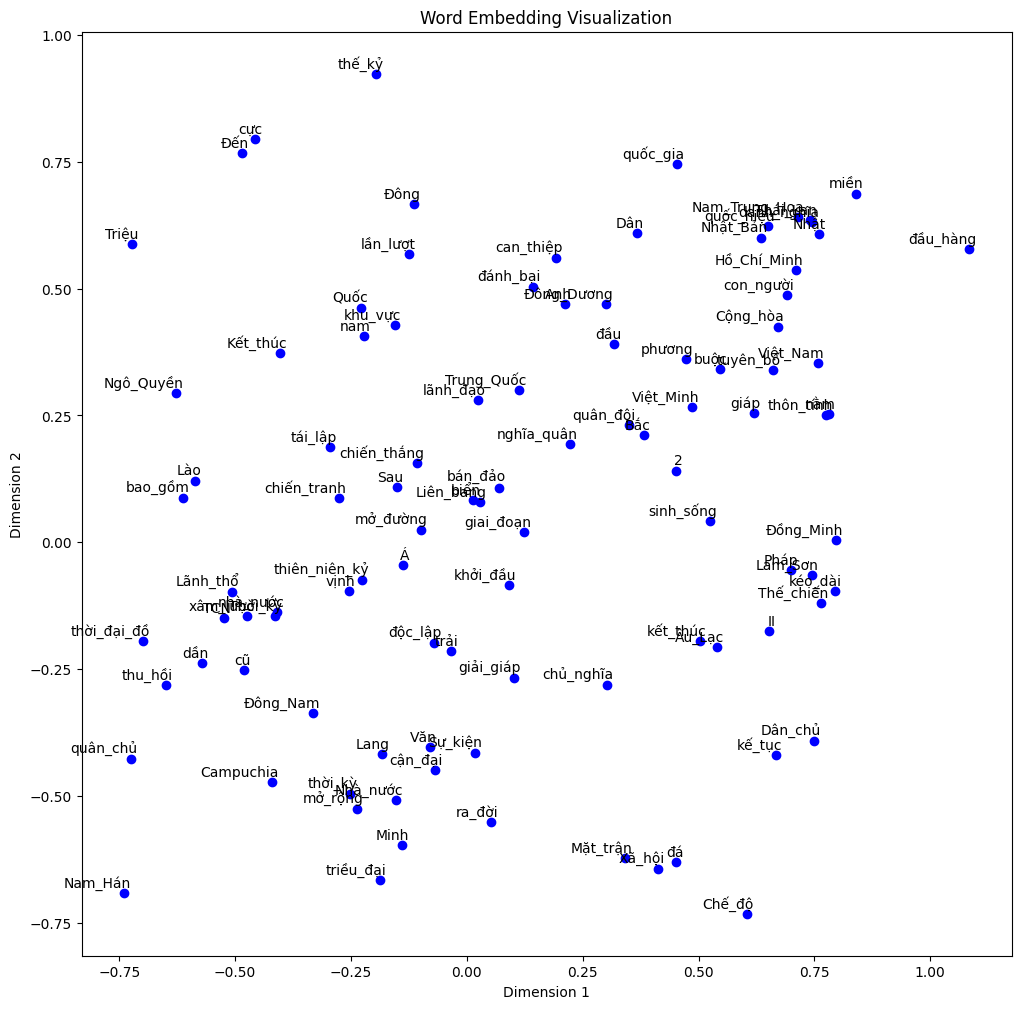

In [ ]:
import matplotlib.pyplot as plt

# Chỉ trực quan hóa một số lượng từ hạn chế
num_words_to_visualize = 100

# Lấy danh sách các từ và vectơ tương ứng
words = list(word_vocab.keys())[:num_words_to_visualize]
vectors = [word_matrix[word_vocab[word]] for word in words]

# Tạo biểu đồ scatter plot
plt.figure(figsize=(12, 12))
for i, word in enumerate(words):
    vector = vectors[i]
    x, y = vector[0], vector[1]
    plt.scatter(x, y, marker='o', color='b')
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Word Embedding Visualization')

plt.show()